In [1]:
# Import libraries
import os
import cv2
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from graph import draw_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2023-11-04 19:55:09.794427: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-04 19:55:09.796533: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-04 19:55:09.830657: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-04 19:55:09.830695: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-04 19:55:09.830723: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
# Set directories
root_dir = os.getcwd()
data_dir = os.path.join(root_dir, 'mosquitoes-dataset')
test_dir = os.path.join(root_dir, 'test-dataset')

In [3]:
tf.random.set_seed(1234)
random.seed(1234)
np.random.seed(1234)

In [4]:
IMG_DIM = 224
IMG_SIZE = (IMG_DIM, IMG_DIM)
IMG_SHAPE = IMG_SIZE + (3,)

In [5]:
# Load data
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                               seed=1234,
                                                               validation_split=0.2,
                                                               subset='both',
                                                               batch_size=32,
                                                               image_size=IMG_SIZE,
                                                               )

Found 1000 files belonging to 2 classes.
Using 800 files for training.
Using 200 files for validation.


In [6]:
class_names = train_ds.class_names
class_num = len(class_names)

In [7]:
# Data augmentation
data_augment = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal_and_vertical'),
                                    tf.keras.layers.RandomRotation(0.3),
                                    tf.keras.layers.RandomContrast(0.2),
                                    ])

In [8]:
# Image resize
image_resize = tf.keras.layers.Resizing(IMG_DIM, IMG_DIM)

In [9]:
# Image normalization
preprocess_input =  tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [11]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet',
                                                     )

In [12]:
base_model.trainable = False

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(class_num, activation='softmax')

In [15]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = image_resize(inputs)
x = data_augment(x)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        225798

In [17]:
base_learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'],
              )

In [18]:
initial_epochs = 10

In [19]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    )

Epoch 1/10
25/25 [==============================] - 11s 359ms/step - loss: 1.0055 - accuracy: 0.4375 - val_loss: 0.8273 - val_accuracy: 0.3800
Epoch 2/10
25/25 [==============================] - 8s 321ms/step - loss: 0.8869 - accuracy: 0.5300 - val_loss: 0.7549 - val_accuracy: 0.4750
Epoch 3/10
25/25 [==============================] - 8s 325ms/step - loss: 0.8617 - accuracy: 0.5175 - val_loss: 0.6975 - val_accuracy: 0.5300
Epoch 4/10
25/25 [==============================] - 9s 347ms/step - loss: 0.7875 - accuracy: 0.5537 - val_loss: 0.6467 - val_accuracy: 0.6300
Epoch 5/10
25/25 [==============================] - 9s 350ms/step - loss: 0.7293 - accuracy: 0.6100 - val_loss: 0.6071 - val_accuracy: 0.6600
Epoch 6/10
25/25 [==============================] - 8s 332ms/step - loss: 0.7131 - accuracy: 0.6137 - val_loss: 0.5710 - val_accuracy: 0.7050
Epoch 7/10
25/25 [==============================] - 8s 324ms/step - loss: 0.6361 - accuracy: 0.6750 - val_loss: 0.5433 - val_accuracy: 0.7400
Epoch

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

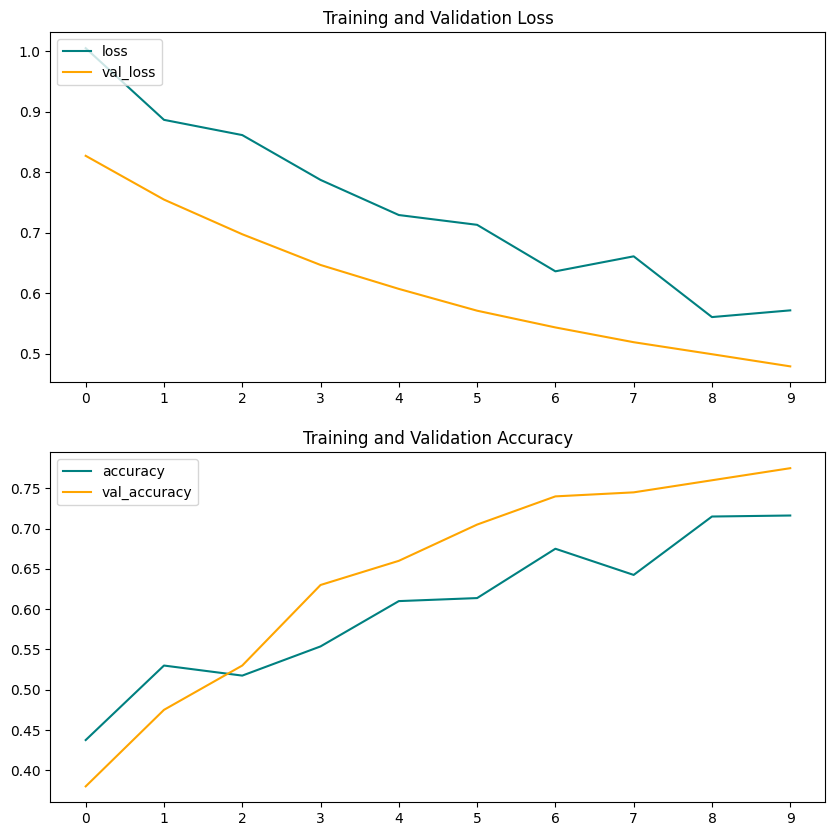

In [21]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(loss, color='teal', label='loss')
plt.plot(val_loss, color='orange', label='val_loss')
plt.xticks(range(history.epoch[-1] + 1))
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(acc, color='teal', label='accuracy')
plt.plot(val_acc, color='orange', label='val_accuracy')
plt.xticks(range(history.epoch[-1] + 1))
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.show()

In [22]:
fine_tune_layers = 10

In [23]:
for layer in base_model.layers[-fine_tune_layers:]:
    layer.trainable = True

In [24]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(
                  learning_rate=base_learning_rate/10),
              metrics=['accuracy'],
              )

In [25]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1]+1,
                         validation_data=val_ds,
                         )

Epoch 11/20
25/25 [==============================] - 10s 345ms/step - loss: 0.5743 - accuracy: 0.7025 - val_loss: 0.4766 - val_accuracy: 0.7750
Epoch 12/20
25/25 [==============================] - 8s 318ms/step - loss: 0.5503 - accuracy: 0.7400 - val_loss: 0.4746 - val_accuracy: 0.7750
Epoch 13/20
25/25 [==============================] - 8s 306ms/step - loss: 0.5654 - accuracy: 0.7275 - val_loss: 0.4726 - val_accuracy: 0.7750
Epoch 14/20
25/25 [==============================] - 8s 311ms/step - loss: 0.5645 - accuracy: 0.7225 - val_loss: 0.4705 - val_accuracy: 0.7800
Epoch 15/20
25/25 [==============================] - 8s 314ms/step - loss: 0.5128 - accuracy: 0.7487 - val_loss: 0.4686 - val_accuracy: 0.7800
Epoch 16/20
25/25 [==============================] - 8s 309ms/step - loss: 0.5532 - accuracy: 0.7175 - val_loss: 0.4667 - val_accuracy: 0.7800
Epoch 17/20
25/25 [==============================] - 8s 312ms/step - loss: 0.5671 - accuracy: 0.7287 - val_loss: 0.4648 - val_accuracy: 0.790

In [26]:
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

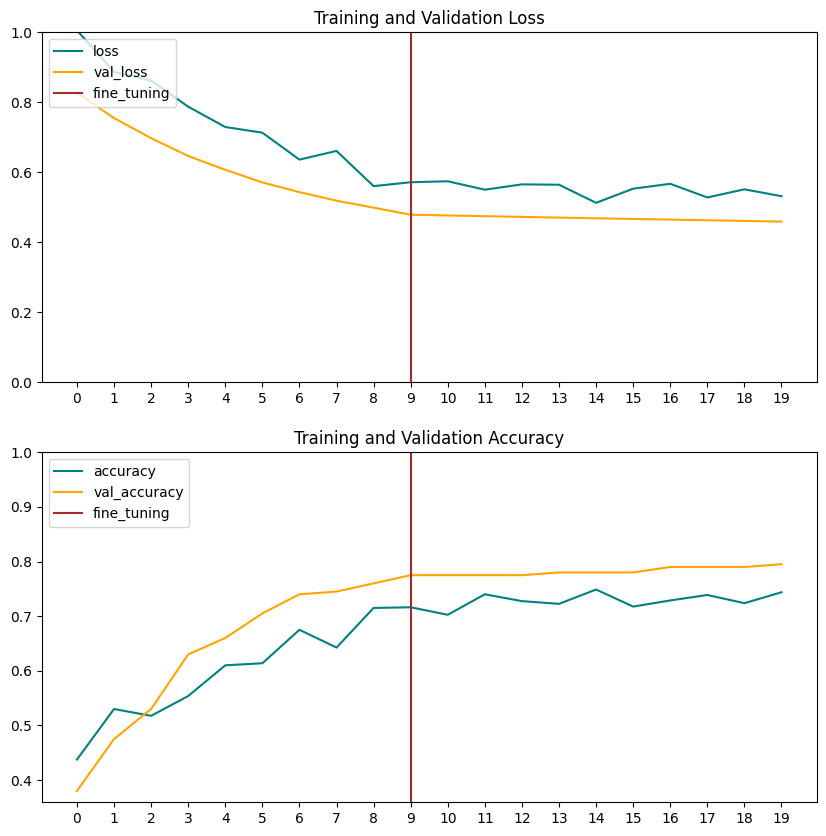

In [27]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(loss, color='teal', label='loss')
plt.plot(val_loss, color='orange', label='val_loss')
plt.xticks(range(history_fine.epoch[-1]+1))
plt.ylim([0, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), color='brown', label='fine_tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(acc, color='teal', label='accuracy')
plt.plot(val_acc, color='orange', label='val_accuracy')
plt.xticks(range(history_fine.epoch[-1]+1))
plt.ylim([min(plt.ylim()), 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), color='brown', label='fine_tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.show()

In [28]:
test_ds_count = 0
for r, d, f in os.walk(test_dir):
    test_ds_count += len(f)

In [29]:
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                      seed=1234,
                                                      image_size=IMG_SIZE,
                                                      batch_size=test_ds_count,
                                                      )

Found 193 files belonging to 2 classes.


In [30]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
yhat = model.predict_on_batch(image_batch)

yhat = tf.nn.softmax(yhat)

print('Predictions:\n', yhat.numpy())

label_yhat = np.empty(0, dtype=int)
for i in range(test_ds_count):
    label_yhat= np.append(label_yhat, np.argmax(yhat[i]))

print('True labels:\n', label_batch)
print('Predicted labels:\n', label_yhat)

Predictions:
 [[0.4255264  0.57447356]
 [0.44040254 0.5595975 ]
 [0.35272738 0.64727265]
 [0.47647905 0.523521  ]
 [0.4552635  0.54473644]
 [0.36519143 0.63480854]
 [0.32166594 0.67833406]
 [0.597281   0.402719  ]
 [0.7111568  0.2888432 ]
 [0.42303967 0.5769603 ]
 [0.48263577 0.51736426]
 [0.52959764 0.47040242]
 [0.36745217 0.63254786]
 [0.3210624  0.6789376 ]
 [0.46474645 0.5352536 ]
 [0.6291346  0.3708654 ]
 [0.5830868  0.4169132 ]
 [0.36902818 0.6309717 ]
 [0.42288336 0.57711667]
 [0.41920647 0.5807935 ]
 [0.4681213  0.5318787 ]
 [0.47844455 0.5215554 ]
 [0.34690472 0.6530953 ]
 [0.31709346 0.6829065 ]
 [0.36594254 0.63405746]
 [0.5871576  0.4128424 ]
 [0.5580186  0.4419814 ]
 [0.49652213 0.5034779 ]
 [0.5891675  0.41083252]
 [0.6048763  0.3951237 ]
 [0.6261299  0.37387007]
 [0.35838237 0.64161766]
 [0.60453993 0.3954601 ]
 [0.44023138 0.5597687 ]
 [0.6483186  0.35168138]
 [0.5983834  0.40161654]
 [0.6213012  0.37869883]
 [0.64943266 0.35056734]
 [0.6362972  0.3637028 ]
 [0.3565755

In [31]:
cm = confusion_matrix(label_batch, label_yhat)
print(cm)

[[44 58]
 [24 67]]


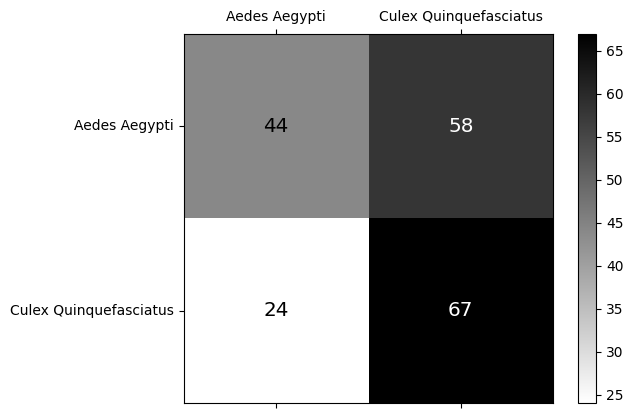

In [32]:
draw_confusion_matrix(cm, class_names)

In [33]:
""" cm_disp = ConfusionMatrixDisplay.from_predictions(y_true=label_batch,
                                                  y_pred=label_yhat,
                                                  display_labels=class_names,
                                                  cmap=plt.cm.gray_r,
                                                  ) """

' cm_disp = ConfusionMatrixDisplay.from_predictions(y_true=label_batch,\n                                                  y_pred=label_yhat,\n                                                  display_labels=class_names,\n                                                  cmap=plt.cm.gray_r,\n                                                  ) '

In [34]:
""" plt.figure(figsize=(20, 20))
for i in range(35):
    plt.subplot(10, 5, i + 1)
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(class_names[np.argmax(yhat[i])])
    plt.axis('off') """

" plt.figure(figsize=(20, 20))\nfor i in range(35):\n    plt.subplot(10, 5, i + 1)\n    plt.imshow(image_batch[i].astype('uint8'))\n    plt.title(class_names[np.argmax(yhat[i])])\n    plt.axis('off') "

In [35]:
""" plt.figure(figsize=(20, 20))
for index, image in enumerate(os.listdir(test_dir)):
    img = cv2.imread(os.path.join(test_dir, image))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_LINEAR)
    x = np.expand_dims(img, 0)

    yhat = model.predict(x)
    yhat = tf.nn.softmax(yhat[0])
    yhat = np.array(yhat)
    
    plt.subplot(10, 5, index + 1)
    plt.imshow(img.astype('uint8'))
    plt.title(class_names[np.argmax(yhat)])
    plt.axis('off') """

" plt.figure(figsize=(20, 20))\nfor index, image in enumerate(os.listdir(test_dir)):\n    img = cv2.imread(os.path.join(test_dir, image))\n    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_LINEAR)\n    x = np.expand_dims(img, 0)\n\n    yhat = model.predict(x)\n    yhat = tf.nn.softmax(yhat[0])\n    yhat = np.array(yhat)\n    \n    plt.subplot(10, 5, index + 1)\n    plt.imshow(img.astype('uint8'))\n    plt.title(class_names[np.argmax(yhat)])\n    plt.axis('off') "

In [36]:
model.save(os.path.join(root_dir, 'models', 'pretrained_model.keras'))